In [1]:
import maelzel.partialtracking as pt
import pitchtools.vectorized as ptv
import csoundengine as ce
from sndfileio import *
import bpf4

In [2]:
samples, sr = sndread("../snd/colours-german-male.flac")
sp = pt.analyze(samples, sr=sr, resolution=50, windowsize=60, hoptime=1/120)
sp

Spectrum(numpartials=10082, start=0.014, end=10.729, density=6351.3)

Sample(dur=10.728639455782313, sr=44100, ch=1)
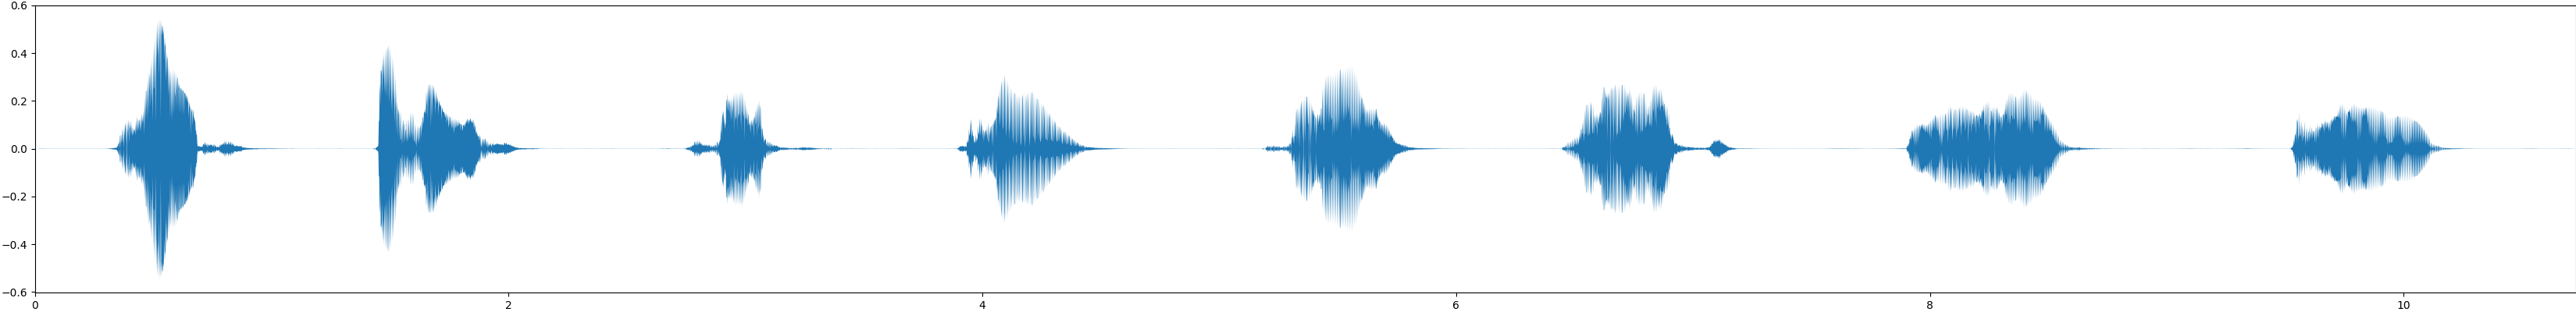

In [3]:
sp.scale(freqfactor=2.0).synthesize()

In [4]:
# Play only noisy partials, amplify them to make them audible
sp.play(minbw=0.3, gain=40)

using libsndfile-1.2.2
sr = 48000.0, kr = 750.000, ksmps = 64
0dBFS level = 1.0, A4 tuning = 440.0
audio buffered in 256 sample-frame blocks
reading 2048-byte blks of shorts from adc:Built-in Audio Analog Stereo: (RAW)
writing 512 sample blks of 64-bit floats to dac:Built-in Audio Analog Stereo:
SECTION 1:


Button(description='Stop', style=ButtonStyle())

Output()

Synth(‖ .playPartials=401.0002 start=.169 dur=-1 ifn=101 iskip=0 inumrows=3065 inumcols=853 kspeed=1 kloop=0 kminfreq=0 kmaxfreq=0 iflags=6 istart=0 istop=0 kfreqscale=1 ichan=1 kbwscale=1 kgain=40 iposition=0 kfreqoffset=0 kminbw=0.3 kmaxbw=1 kminamp=0)

In [5]:
# Leave noise out
sp.play(maxbw=0.05)

Button(description='Stop', style=ButtonStyle())

Output()

Synth(‖ .playPartials=401.0003 start=23.726 dur=-1 ifn=101 iskip=0 inumrows=3065 inumcols=853 kspeed=1 kloop=0 kminfreq=0 kmaxfreq=0 iflags=6 istart=0 istop=0 kfreqscale=1 ichan=1 kbwscale=1 kgain=1 iposition=0 kfreqoffset=0 kminbw=0 kmaxbw=0.05 kminamp=0)

Sample(dur=10.728639455782313, sr=44100, ch=1)
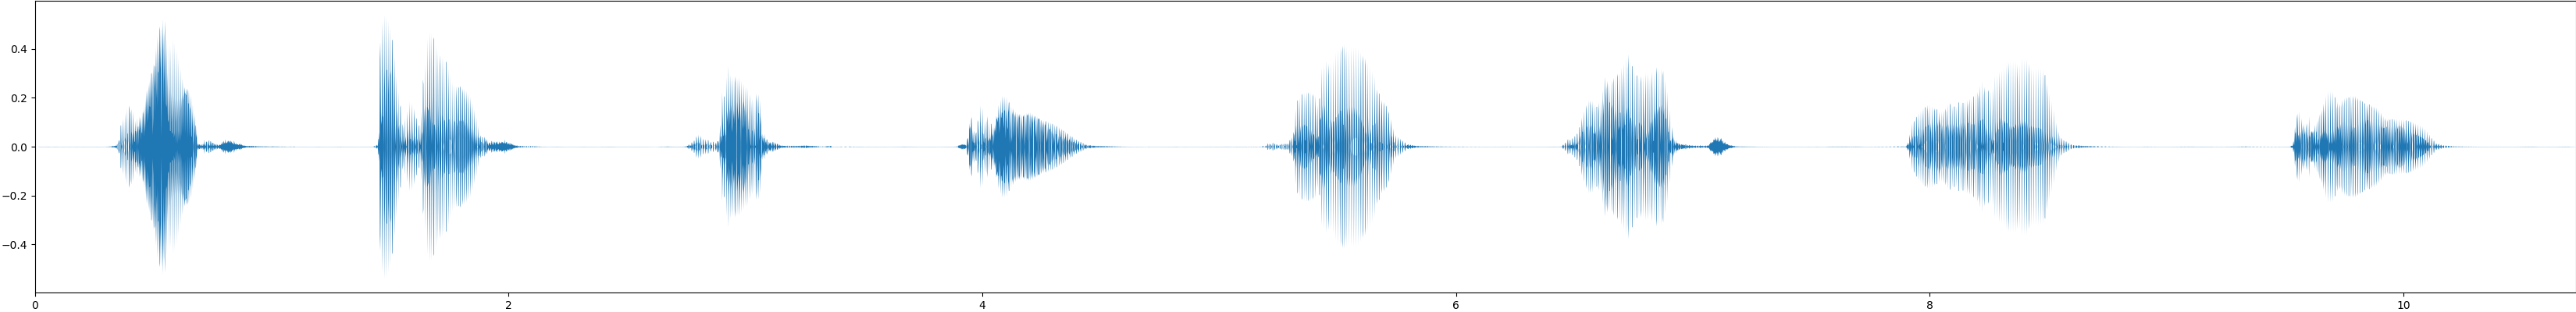

In [6]:
# Remove noisyness
sp2 = sp.scale(bwfactor=0)
sp2.synthesize()

Sample(dur=10.728639455782313, sr=44100, ch=1)
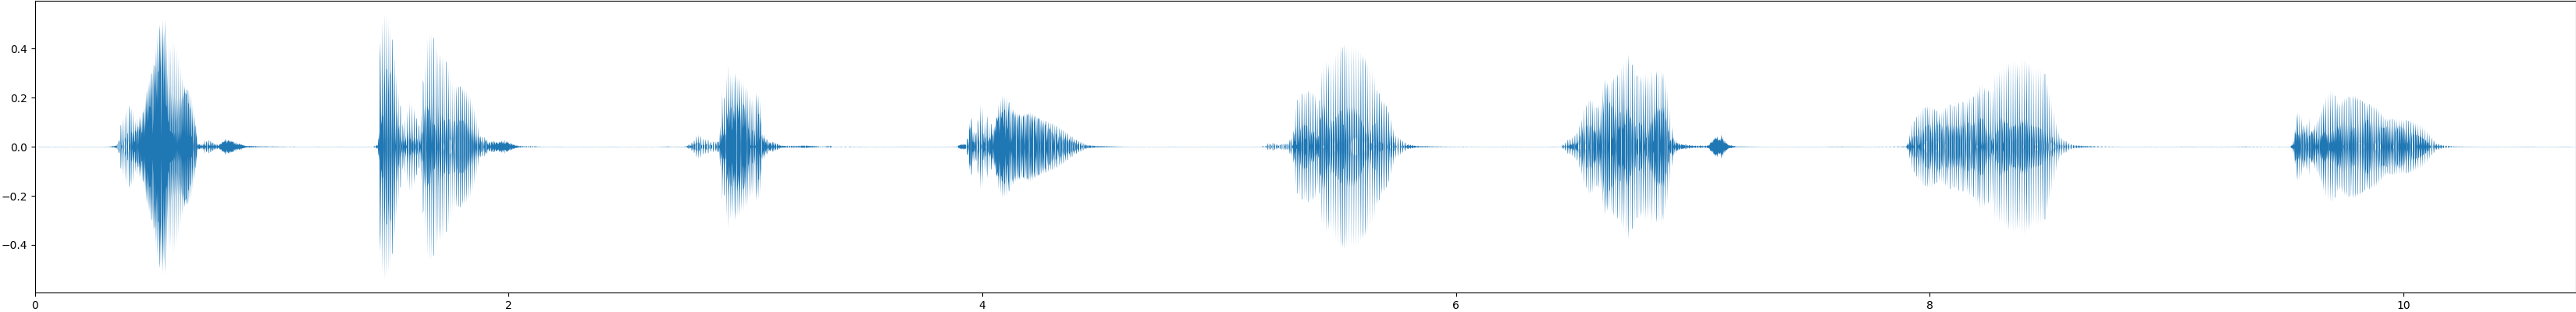

In [32]:
sp2 = sp.scale(bwfactor=1)
sp2.synthesize()

Sample(dur=10.207596371882087, sr=44100, ch=1)
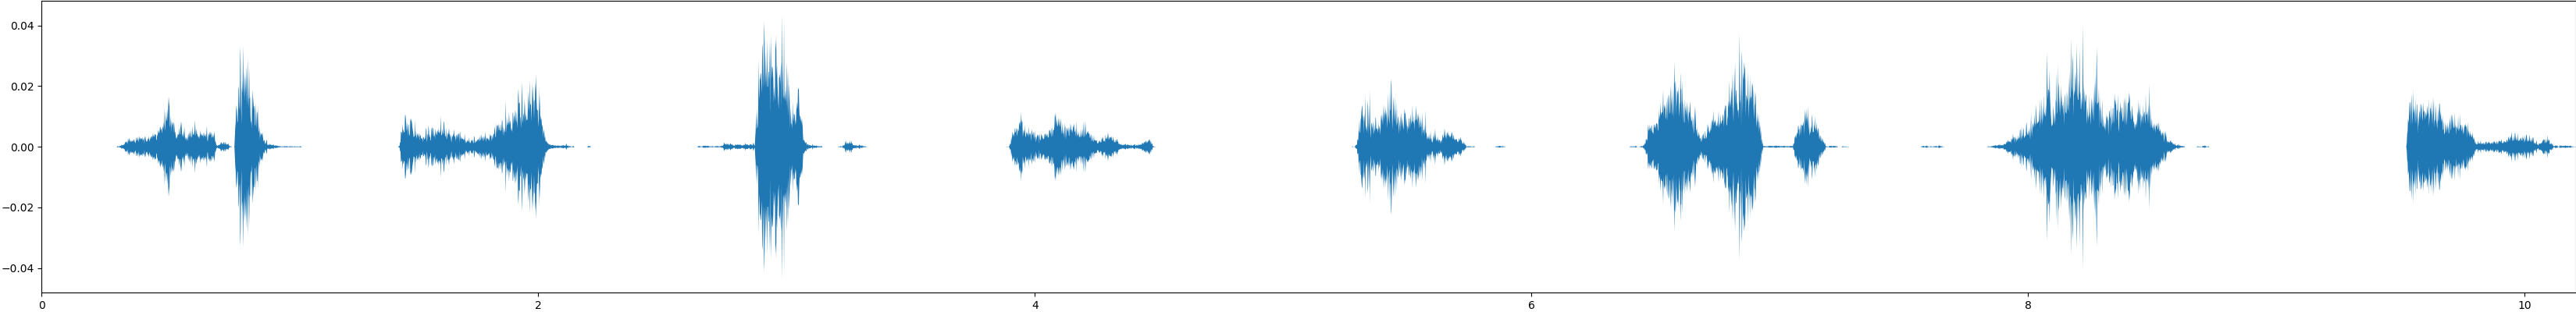

In [7]:
sp.filter(minfreq=2000, maxfreq=4000)[0].scale(bwfactor=20).synthesize()

Playback the voiced and unvoiced parts of the spectrum separately. 

In [4]:
# Create a new session
session = ce.Session()

using libsndfile-1.2.2
sr = 48000.0, kr = 750.000, ksmps = 64
0dBFS level = 1.0, A4 tuning = 440.0
audio buffered in 256 sample-frame blocks
reading 2048-byte blks of shorts from adc:Built-in Audio Analog Stereo: (RAW)
writing 512 sample blks of 64-bit floats to dac:Built-in Audio Analog Stereo:
SECTION 1:


In [5]:
speed = 0.25
with session as s:
    sp.play(speed=speed, freqoffset=0, freqscale=1, maxbw=0.01, gain=1, chan=1, session=session)
    sp.play(speed=speed, freqoffset=0, freqscale=1, minbw=0.01, gain=20, minfreq=2000, chan=2, session=session, bwscale=5)
s

Button(description='Stop Synths', style=ButtonStyle())

Output()

Session(engine0, backend=jack, outdev=Built-in Audio Analog Stereo, synths=2)

In [6]:
def quantize(partial, simp=0.4, steps=2):
    """quantize and simplify partial"""
    
    if simp > 0:
        p2 = partial.simplified(simp)
    else:
        p2 = partial.copy()
    pitches = (ptv.f2m(p2.freqs) / steps).round() * steps
    p2.data[:,1] = ptv.m2f(pitches)
    return p2

In [7]:
quantizedspec = pt.Spectrum([quantize(p, simp=0.2, steps=3) for p in sp.partials])
quantizedspec

Spectrum(numpartials=10082, start=0.014, end=10.729, density=1953.0)

<Axes: >

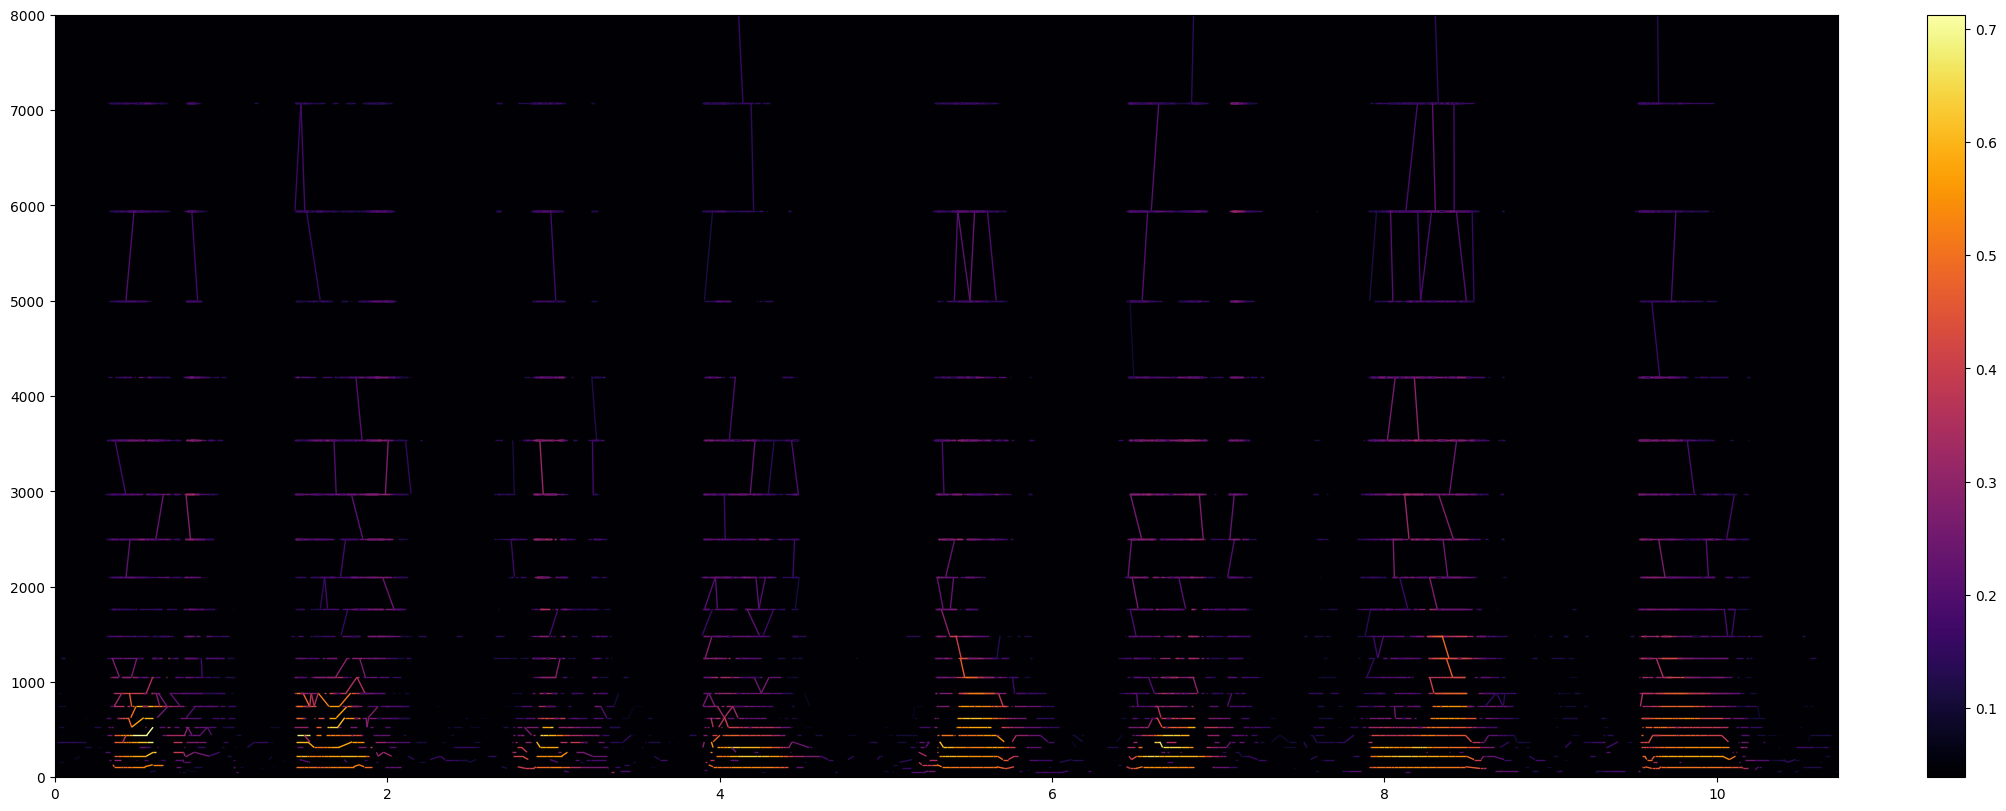

In [8]:
%matplotlib inline
quantizedspec.plot(maxfreq=8000, exp=0.2)

In [9]:
quantizedspec.play()

using libsndfile-1.2.2
sr = 48000.0, kr = 750.000, ksmps = 64
0dBFS level = 1.0, A4 tuning = 440.0
audio buffered in 256 sample-frame blocks
reading 2048-byte blks of shorts from adc:Built-in Audio Analog Stereo: (RAW)
writing 512 sample blks of 64-bit floats to dac:Built-in Audio Analog Stereo:
SECTION 1:


Button(description='Stop', style=ButtonStyle())

Output()

Synth(‖ .playPartials=401.0002 start=.121 dur=-1 ifn=101 iskip=0 inumrows=480 inumcols=1327 kspeed=1 kloop=0 kminfreq=0 kmaxfreq=0 iflags=6 istart=0 istop=0 kfreqscale=1 ichan=1 kbwscale=1 kgain=1 iposition=0 kfreqoffset=0 kminbw=0 kmaxbw=1 kminamp=0)

In [10]:
import numpyx
from maelzel.music import scale

def quantizeToScale(partial, f0="C0", steps=(2, 2, 1, 2, 2, 2, 1), factor=0.9):
    pitches = scale.pitchscale(f0, steps=steps)
    scaleFreqs = ptv.m2f(pitches)
    def transform(freqs):
        nearestfreqs = numpyx.nearestitem(scaleFreqs, freqs)
        return freqs + (nearestfreqs - freqs) * factor
        
    return partial.freqTransform(transform)
    

In [11]:

quantizedspec2 = pt.Spectrum([quantizeToScale(p.simplified(0.3), f0="A1", steps=(2, 1, 2, 2, 1, 2, 2), factor=0.95) for p in sp.partials])
quantizedspec2

Spectrum(numpartials=10082, start=0.014, end=10.729, density=2299.4)

Sample(dur=42.91460317460317, sr=44100, ch=1)
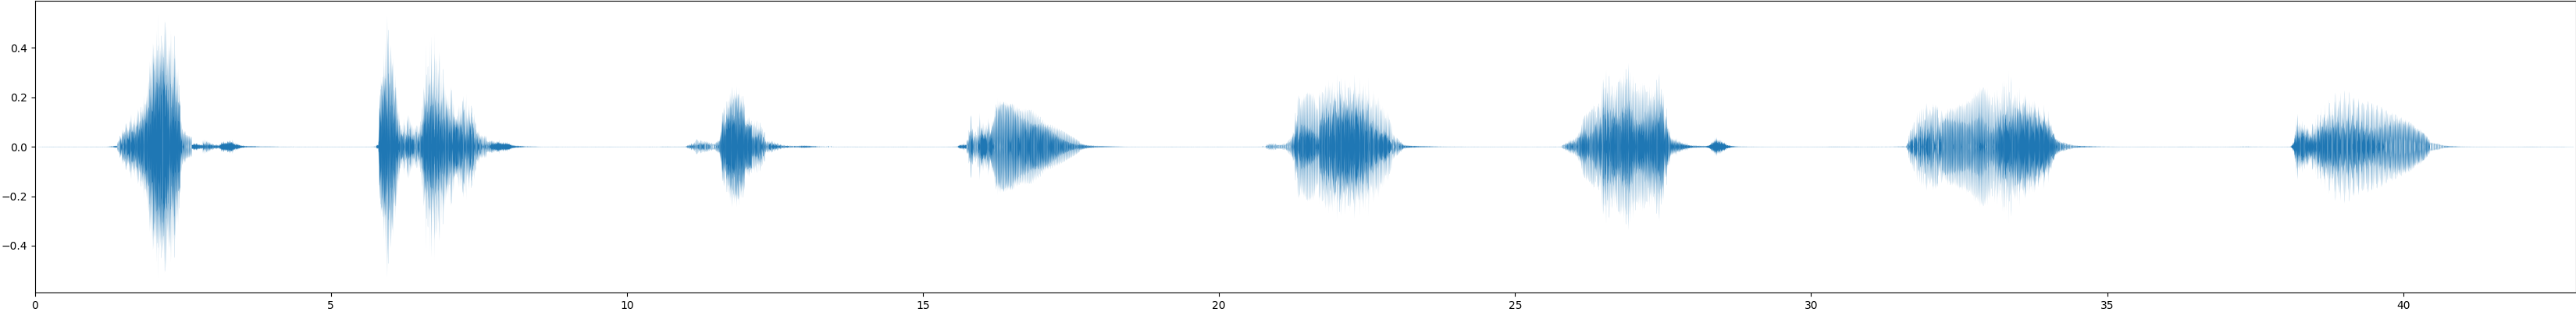

In [12]:
quantizedspec2.synthesize(speed=0.25)